# Oklahoma County Property Analysis

In [43]:
# Install required libraries
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, ElasticNet
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import seaborn as sns
from scipy import stats

## 1. Exploratory Data Analysis

### Import CSV file

In [44]:
# Read the CSV file into a DataFrame
df = pd.read_csv('output.csv')

# Remove specific addresses
remove_adresses = ['900 HANGAR DR']
df = df[~df['address'].isin(remove_adresses)]

# Convert string representations of Python dictionaries back into the correct data type
df['market_values'] = df['market_values'].apply(ast.literal_eval)
df['sales_prices'] = df['sales_prices'].apply(ast.literal_eval)


### Clean Data and Add Columns

In [45]:
# Extract the most recent sales price and market value
get_most_recent = lambda x: next(iter(x.values())) if x else None
df['most_recent_sales_price'] = df['sales_prices'].apply(get_most_recent)
df['most_recent_market_value'] = df['market_values'].apply(get_most_recent)

# Create total square footage feature by adding unfin_attic_sqft to the square_feet column
df['total_sqft'] = df['square_feet'] + df['unfin_attic_sqft']

# Calculate price/square foot
df['price/square_foot'] = df['most_recent_sales_price'] / df['square_feet']

# Calculate value difference between the most recent Market Value and Sales Price
df['value_diff'] = df['most_recent_market_value'] - df['most_recent_sales_price']

# Create binary value based on if the house has a garage
df['has_garage'] = df['garage_sqft'].apply(lambda x: 1 if x > 0 else 0)

# Create binary value based on if the house has a garage apartment
df['has_apt'] = df['garage_apt_sqft'].apply(lambda x: 1 if x > 0 else 0)

# Display the DataFrame
df


,address,square_feet,market_values,sales_prices,year_built,bedrooms,bathrooms,garage_sqft,garage_apt_sqft,porch_sqft,unfin_attic_sqft,most_recent_sales_price,most_recent_market_value,total_sqft,price/square_foot,value_diff,has_garage,has_apt
0,1000 PEDALERS LN,1024.0,"{2023: 331500, 2022: 284500, 2021: 243000, 202...",{2019: 232500},2018.0,3.0,1.5,0.0,0.0,71.0,0.0,232500.0,331500.0,1024.0,227.050781,99000.0,0,0
1,1001 PEDALERS LN,1167.0,"{2023: 369000, 2022: 317000, 2021: 267500, 202...",{2019: 246000},2018.0,3.0,1.5,0.0,0.0,69.0,0.0,246000.0,369000.0,1167.0,210.796915,123000.0,0,0
2,1004 PEDALERS LN,766.0,"{2023: 281500, 2022: 242000, 2021: 210500, 202...","{2020: 215000, 2019: 197500}",2018.0,2.0,1.5,0.0,0.0,56.0,0.0,215000.0,281500.0,766.0,280.678851,66500.0,0,0
3,1005 PEDALERS LN,756.0,"{2023: 277500, 2022: 237500, 2021: 208000, 202...",{2019: 191000},2018.0,1.0,1.0,0.0,0.0,102.0,0.0,191000.0,277500.0,756.0,252.645503,86500.0,0,0
4,1008 PEDALERS LN,1164.0,"{2023: 353500, 2022: 303000, 2021: 259500, 202...",{2019: 248500},2018.0,3.0,1.5,0.0,0.0,72.0,0.0,248500.0,353500.0,1164.0,213.487973,105000.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,1833 WHEELER ST,1535.0,"{2023: 484000, 2022: 419000}",{2021: 429000},2020.0,3.0,3.0,448.0,0.0,198.0,0.0,429000.0,484000.0,1535.0,279.478827,55000.0,1,0
164,1837 WHEELER ST,1535.0,"{2023: 497000, 2022: 497000}",{2021: 511000},2020.0,3.0,3.0,448.0,0.0,198.0,0.0,511000.0,497000.0,1535.0,332.899023,-14000.0,1,0
165,1000 HANGAR DR,NaN,{},{},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
167,901 HANGAR DR,NaN,{},{},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0


### Remove instances where there is no value for Square Feet, Most Recent Market Value, and Most Recent Sales Price

* These homes have not been finished and therefore should not be considered in this analysis.

In [46]:
# Remove NaN values from the specified columns
filtered_df = df.dropna(subset=['square_feet', 'most_recent_market_value', 'most_recent_sales_price'])
print("Filtered Shape: ", filtered_df.shape)
filtered_df

Filtered Shape:  (126, 18)


,address,square_feet,market_values,sales_prices,year_built,bedrooms,bathrooms,garage_sqft,garage_apt_sqft,porch_sqft,unfin_attic_sqft,most_recent_sales_price,most_recent_market_value,total_sqft,price/square_foot,value_diff,has_garage,has_apt
0,1000 PEDALERS LN,1024.0,"{2023: 331500, 2022: 284500, 2021: 243000, 202...",{2019: 232500},2018.0,3.0,1.5,0.0,0.0,71.0,0.0,232500.0,331500.0,1024.0,227.050781,99000.0,0,0
1,1001 PEDALERS LN,1167.0,"{2023: 369000, 2022: 317000, 2021: 267500, 202...",{2019: 246000},2018.0,3.0,1.5,0.0,0.0,69.0,0.0,246000.0,369000.0,1167.0,210.796915,123000.0,0,0
2,1004 PEDALERS LN,766.0,"{2023: 281500, 2022: 242000, 2021: 210500, 202...","{2020: 215000, 2019: 197500}",2018.0,2.0,1.5,0.0,0.0,56.0,0.0,215000.0,281500.0,766.0,280.678851,66500.0,0,0
3,1005 PEDALERS LN,756.0,"{2023: 277500, 2022: 237500, 2021: 208000, 202...",{2019: 191000},2018.0,1.0,1.0,0.0,0.0,102.0,0.0,191000.0,277500.0,756.0,252.645503,86500.0,0,0
4,1008 PEDALERS LN,1164.0,"{2023: 353500, 2022: 303000, 2021: 259500, 202...",{2019: 248500},2018.0,3.0,1.5,0.0,0.0,72.0,0.0,248500.0,353500.0,1164.0,213.487973,105000.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,1821 WHEELER ST,1535.0,"{2023: 484000, 2022: 419000}",{2021: 429000},2020.0,3.0,3.0,448.0,0.0,198.0,0.0,429000.0,484000.0,1535.0,279.478827,55000.0,1,0
161,1825 WHEELER ST,1498.0,"{2023: 430000, 2022: 430000}",{2021: 434000},2020.0,3.0,2.5,448.0,0.0,198.0,0.0,434000.0,430000.0,1498.0,289.719626,-4000.0,1,0
162,1829 WHEELER ST,1496.0,"{2023: 474000, 2022: 410000}",{2021: 429000},2020.0,3.0,2.5,448.0,0.0,198.0,0.0,429000.0,474000.0,1496.0,286.764706,45000.0,1,0
163,1833 WHEELER ST,1535.0,"{2023: 484000, 2022: 419000}",{2021: 429000},2020.0,3.0,3.0,448.0,0.0,198.0,0.0,429000.0,484000.0,1535.0,279.478827,55000.0,1,0


### Heatmap

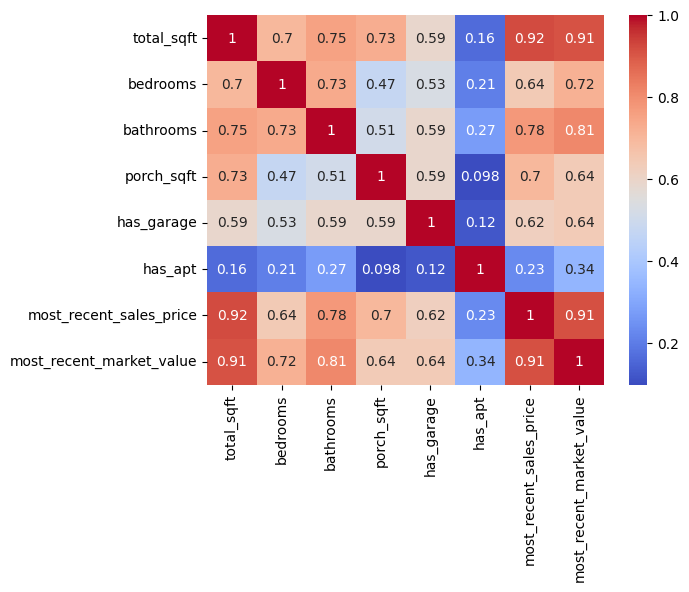

In [47]:
# Create dataframe of worthwhile features to plot
plotworthy_df = pd.DataFrame(data=filtered_df[['total_sqft', 'bedrooms', 'bathrooms', 'porch_sqft', 'has_garage', 'has_apt', 'most_recent_sales_price', 'most_recent_market_value']])

# Compute the correlation matrix
corr_matrix = plotworthy_df.corr()

# Plot the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

### Pair Plots

/Users/kaylachristopher/Desktop/Code-Fellows/Projects/Wheeler_Home_Values/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


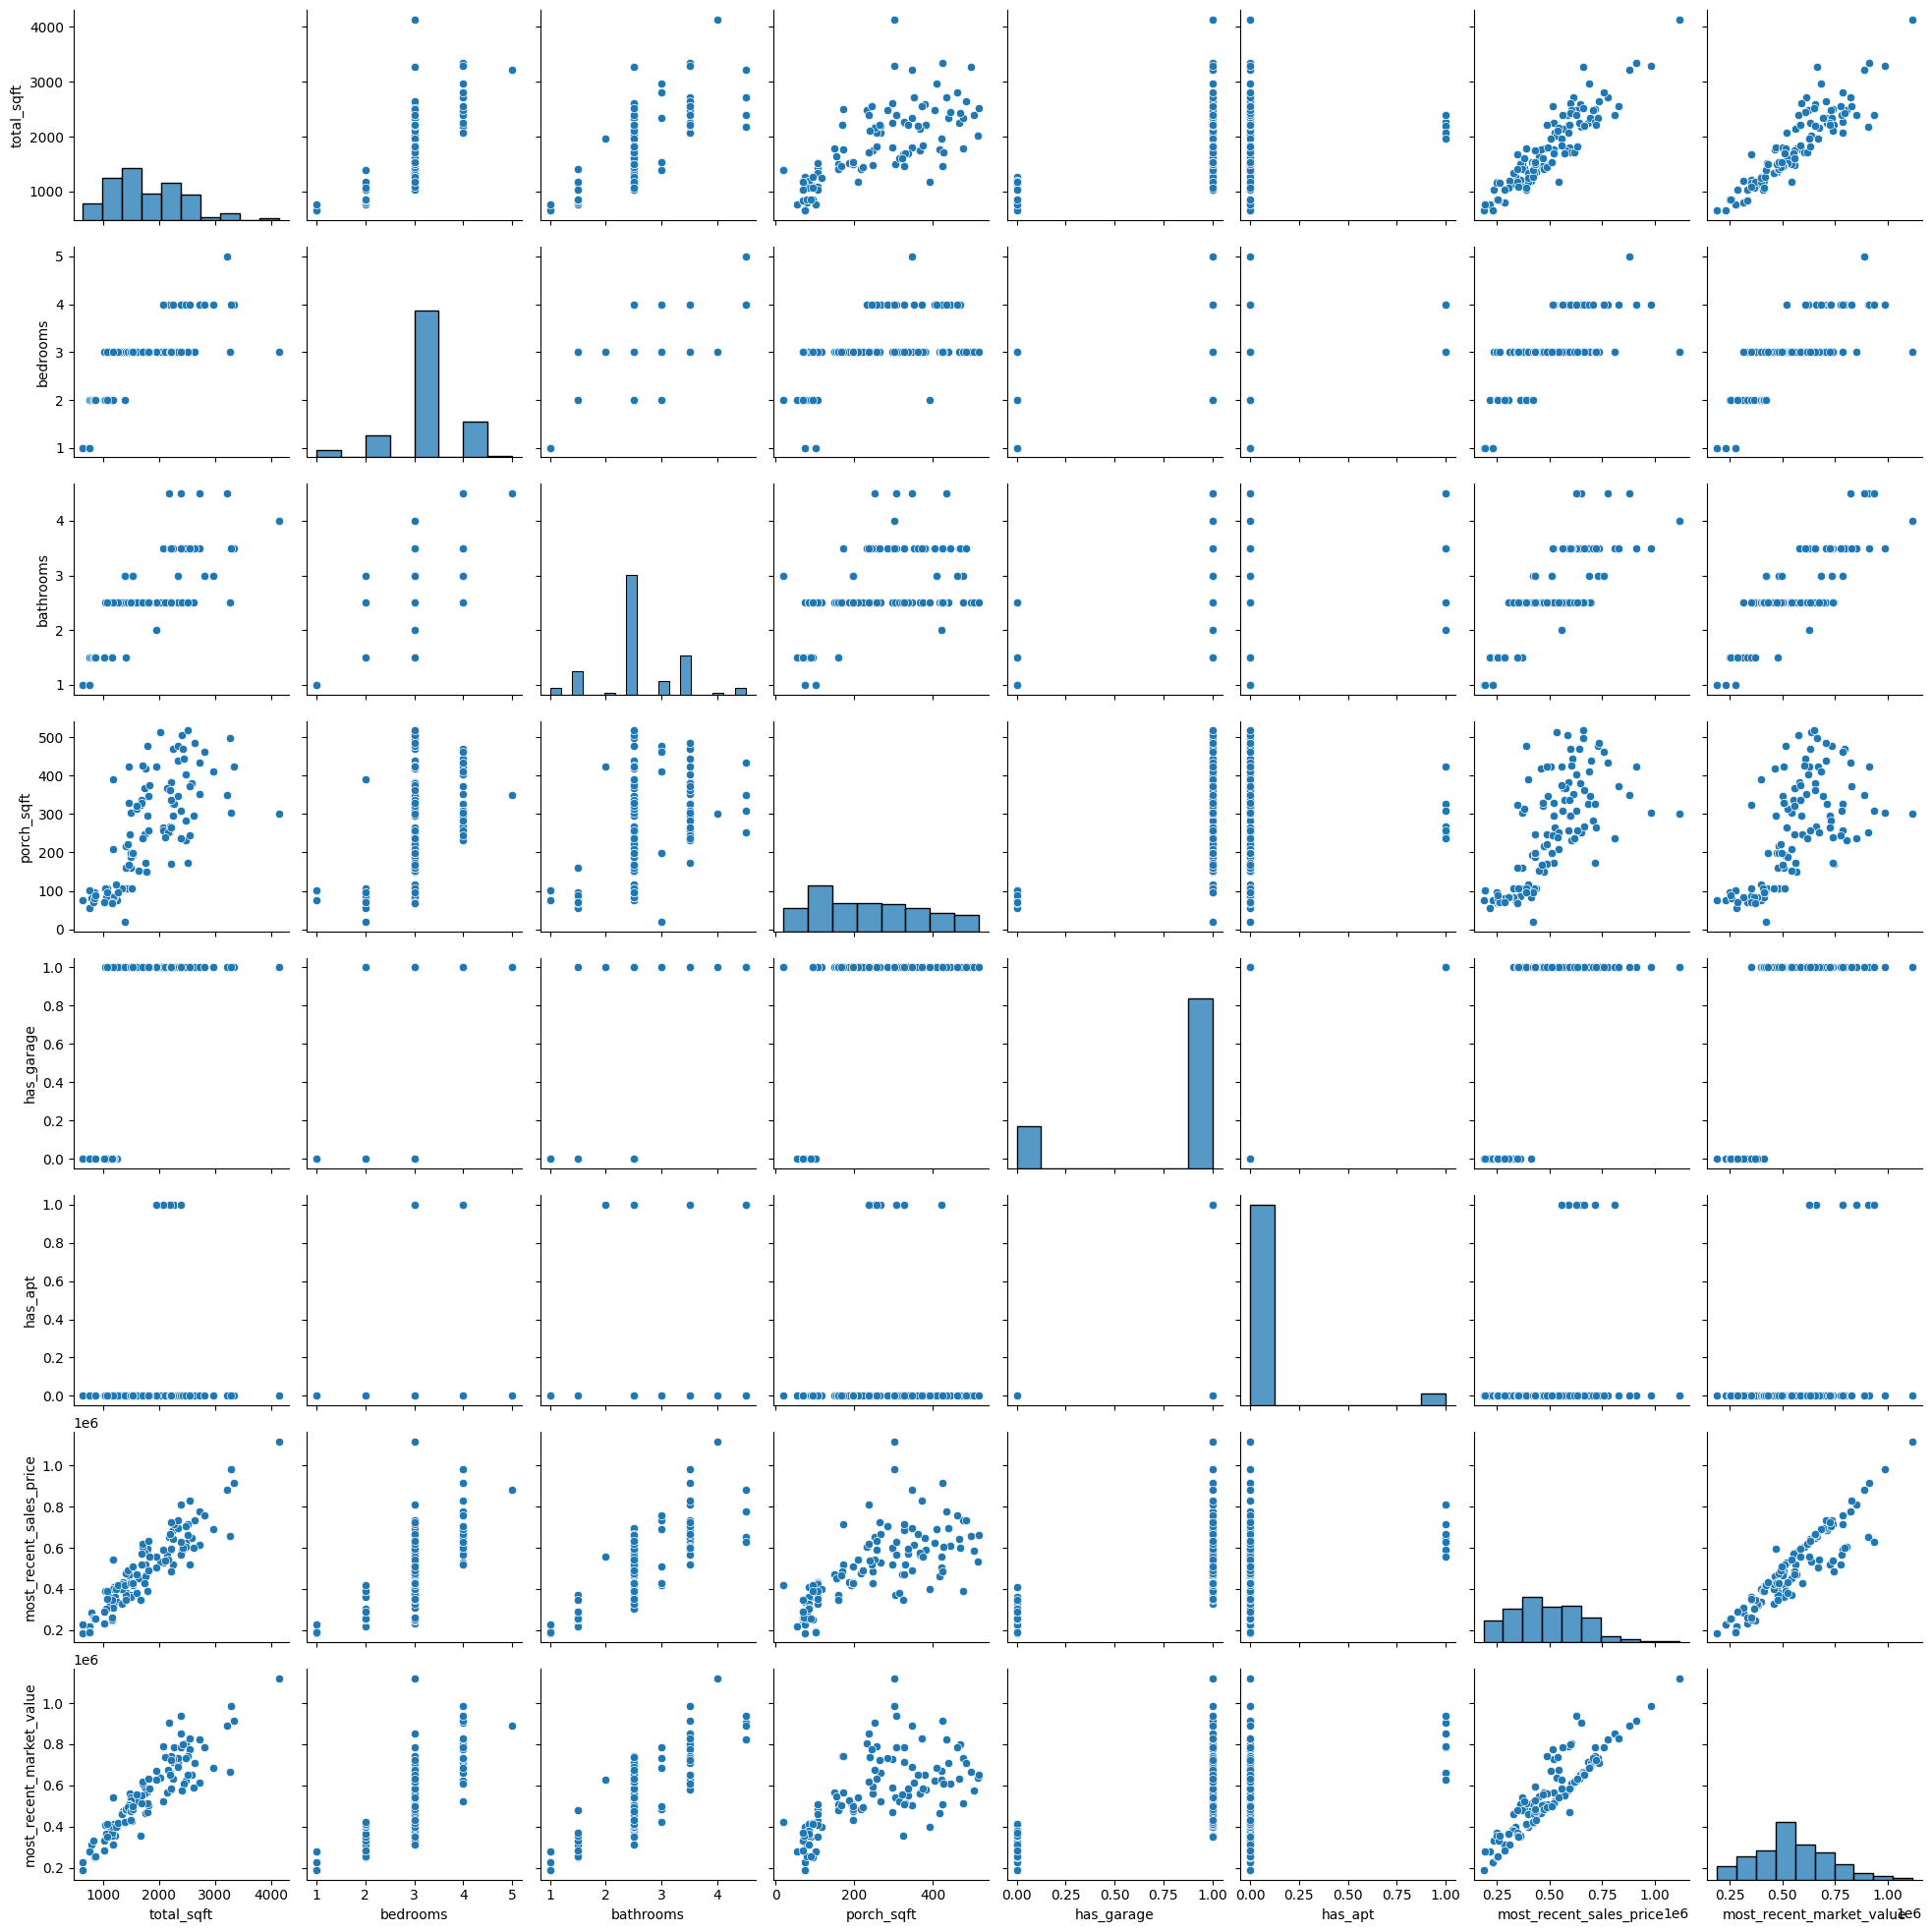

In [48]:
# Create a pair plot
sns.pairplot(plotworthy_df)
plt.show()

### Remove Outliers from the Datafame

In [49]:
# Create new dataframe
data = filtered_df.copy()

# Specify the column to remove outliers from
column = 'square_feet'

# Calculate Z-scores for the specified column
mean = data[column].mean()
std = data[column].std()
z_scores = (data[column] - mean) / std

# Define a threshold for outliers (e.g., 2 standard deviations)
threshold = 2

outliers = np.abs(z_scores) > threshold

print("Outliers found:", outliers.sum())

# Remove outliers
df_no_outliers = data[~outliers]

print("Shape of resulting dataframe with no outliers: ", df_no_outliers.shape)
df_no_outliers


Outliers found: 4
Shape of resulting dataframe with no outliers:  (122, 18)


,address,square_feet,market_values,sales_prices,year_built,bedrooms,bathrooms,garage_sqft,garage_apt_sqft,porch_sqft,unfin_attic_sqft,most_recent_sales_price,most_recent_market_value,total_sqft,price/square_foot,value_diff,has_garage,has_apt
0,1000 PEDALERS LN,1024.0,"{2023: 331500, 2022: 284500, 2021: 243000, 202...",{2019: 232500},2018.0,3.0,1.5,0.0,0.0,71.0,0.0,232500.0,331500.0,1024.0,227.050781,99000.0,0,0
1,1001 PEDALERS LN,1167.0,"{2023: 369000, 2022: 317000, 2021: 267500, 202...",{2019: 246000},2018.0,3.0,1.5,0.0,0.0,69.0,0.0,246000.0,369000.0,1167.0,210.796915,123000.0,0,0
2,1004 PEDALERS LN,766.0,"{2023: 281500, 2022: 242000, 2021: 210500, 202...","{2020: 215000, 2019: 197500}",2018.0,2.0,1.5,0.0,0.0,56.0,0.0,215000.0,281500.0,766.0,280.678851,66500.0,0,0
3,1005 PEDALERS LN,756.0,"{2023: 277500, 2022: 237500, 2021: 208000, 202...",{2019: 191000},2018.0,1.0,1.0,0.0,0.0,102.0,0.0,191000.0,277500.0,756.0,252.645503,86500.0,0,0
4,1008 PEDALERS LN,1164.0,"{2023: 353500, 2022: 303000, 2021: 259500, 202...",{2019: 248500},2018.0,3.0,1.5,0.0,0.0,72.0,0.0,248500.0,353500.0,1164.0,213.487973,105000.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,1821 WHEELER ST,1535.0,"{2023: 484000, 2022: 419000}",{2021: 429000},2020.0,3.0,3.0,448.0,0.0,198.0,0.0,429000.0,484000.0,1535.0,279.478827,55000.0,1,0
161,1825 WHEELER ST,1498.0,"{2023: 430000, 2022: 430000}",{2021: 434000},2020.0,3.0,2.5,448.0,0.0,198.0,0.0,434000.0,430000.0,1498.0,289.719626,-4000.0,1,0
162,1829 WHEELER ST,1496.0,"{2023: 474000, 2022: 410000}",{2021: 429000},2020.0,3.0,2.5,448.0,0.0,198.0,0.0,429000.0,474000.0,1496.0,286.764706,45000.0,1,0
163,1833 WHEELER ST,1535.0,"{2023: 484000, 2022: 419000}",{2021: 429000},2020.0,3.0,3.0,448.0,0.0,198.0,0.0,429000.0,484000.0,1535.0,279.478827,55000.0,1,0


# Test different types of Linear Regression models

In [50]:
# Break into features and labels
X = df_no_outliers[['total_sqft', 'year_built', 'bedrooms', 'bathrooms', 'has_garage', 'has_apt']].values
y = df_no_outliers['most_recent_market_value'].values

# Break out training and testing portions
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Create a function to evaluate different models
def evaluate_model(model, X, y):
    kfold = KFold(n_splits=10, shuffle=True, random_state=1)
    mse_scores = -cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_squared_error')
    r2_scores = cross_val_score(model, X, y, cv=kfold, scoring='r2')

    print(f'Mean Squared Error: {np.mean(mse_scores)}')
    print(f'R2 Score: {np.mean(r2_scores)}')

# Identify the numerical and categorical columns
numerical_columns = [0, 1, 2, 3]  # Indices for the numerical columns in X
binary_columns = [4, 5]  # Indices for the binary columns in X

# Define transformers for preprocessing
numerical_transformer = StandardScaler()  # You can also use MinMaxScaler()
binary_transformer = 'passthrough'

# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('binary', binary_transformer, binary_columns)
    ])

# Linear Regression
model1 = Pipeline(steps=[('preprocessor', preprocessor),
                         ('regressor', LinearRegression())])
print("Linear Regression:")
evaluate_model(model1, X, y)

# Ridge Regression
model2 = Pipeline(steps=[('preprocessor', preprocessor),
                         ('regressor', Ridge(alpha=1.0))])
print("\nRidge Regression:")
evaluate_model(model2, X, y)

# Lasso Regression
alphas = np.logspace(-4, 0, 50)  # Define a range of alpha values to test
lasso_cv_model = LassoCV(alphas=alphas, cv=5).fit(X_train, y_train)
best_alpha = lasso_cv_model.alpha_  # Get the best alpha value
model3 = Pipeline(steps=[('preprocessor', preprocessor),
                         ('regressor', Lasso(alpha=best_alpha))])
print("\nLasso Regression:")
print("Best alpha value:", best_alpha)
evaluate_model(model3, X, y)

# ElasticNet Regression
model4 = Pipeline(steps=[('preprocessor', preprocessor),
                         ('regressor', ElasticNet(alpha=0.1, l1_ratio=0.5))])
print("\nElasticNet Regression:")
evaluate_model(model4, X, y)

Linear Regression:
Mean Squared Error: 3422539160.541835
R2 Score: 0.8485003464789775

Ridge Regression:
Mean Squared Error: 3394375867.4328723
R2 Score: 0.8496103728635667

Lasso Regression:
Best alpha value: 1.0
Mean Squared Error: 3422494749.04324
R2 Score: 0.848501583265979

ElasticNet Regression:
Mean Squared Error: 3576927002.549428
R2 Score: 0.8398622992935245


### It appears the Ridge Regression has the best performance

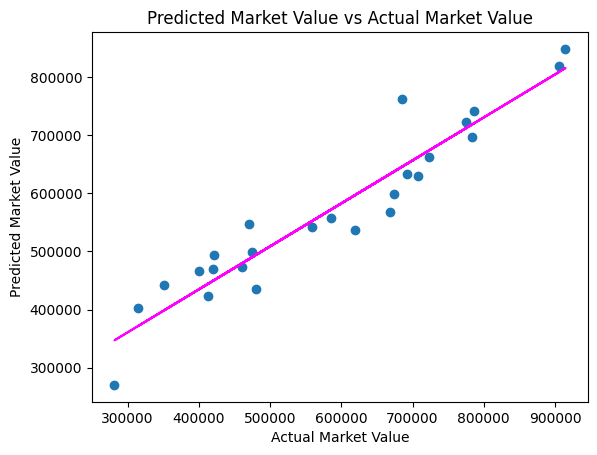

Predicted Market Value:  $556,994


In [51]:
# Use model2 which is associated with the Ridge Regression model in the previous code block
market_model = model2.fit(X_train, y_train)
predictions = market_model.predict(X_test)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Market Value')
plt.ylabel('Predicted Market Value')
plt.title('Predicted Market Value vs Actual Market Value')

# Overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

# Predict market value
predicted_market_value = market_model.predict([[1700, 2021, 3, 3, 1, 0]])[0]
formatted_market_value = "${:,.0f}".format(predicted_market_value)
print("Predicted Market Value: ", formatted_market_value)

## Sales Price Linear Regression

MSE: 2386923510.739582
RMSE: 48856.151206778275
R2: 0.8756455684745438


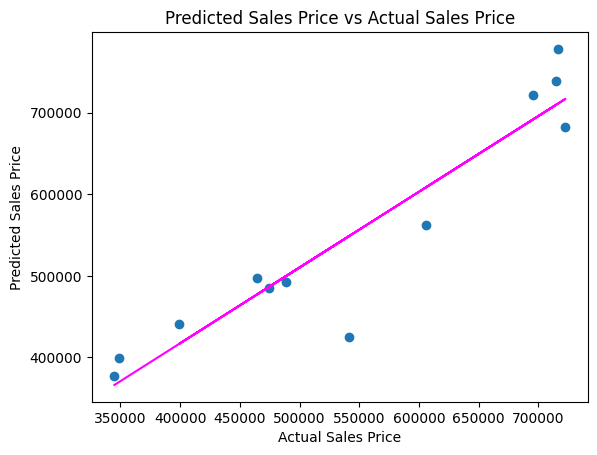

In [52]:
# Clean the data by removing sales data from before 2022 and break into features and labels
recent_df = df_no_outliers[df_no_outliers['sales_prices'].apply(lambda x: next(iter(x), None)) >= 2022]
X = recent_df[['total_sqft', 'year_built', 'bedrooms', 'bathrooms', 'has_garage', 'has_apt']].values
y = recent_df['most_recent_sales_price'].values

# Split data into training/testing groups and create a model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)
sales_model = LinearRegression().fit(X_train, y_train)
predictions = sales_model.predict(X_test)

# Determine how well the model predicts
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Sales Price')
plt.ylabel('Predicted Sales Price')
plt.title('Predicted Sales Price vs Actual Sales Price')

# Overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

## Un-comment this section to allow the user to input custom home information to predict

In [53]:
# # Allows user to input square footage to be used in the prediction
# total_sqft = int(input("Enter a total square footage amount (ex. 2050) to predict sales price and market value:"))
# year_built = int(input("Enter a year that the home was built (ex. 2019) to predict sales price and market value:"))
# bedrooms = int(input("Enter the number of bedrooms (ex. 3) to predict sales price and market value:"))
# bathrooms = int(input("Enter the number of bathrooms (ex. 2.5) to predict sales price and market value:"))
# has_garage = int(input("Enter 1 if there is a garage, 0 if not:"))
# has_apt = int(input("Enter 1 if there is a garage apartment, 0 if not:"))

## Predictions

In [54]:
# Predict sales price
# predicted_sales = sales_model.predict([[total_sqft, year_built, bedrooms, bathrooms, has_garage, has_apt]])[0]
predicted_sales = sales_model.predict([[1800, 2021, 3, 3, 1, 0]])[0]
formatted_sales_price = "${:,.0f}".format(predicted_sales)
print("Predicted Sales Price: ", formatted_sales_price)

# Predict market value
# predicted_market_value = market_model.predict([[total_sqft, year_built, bedrooms, bathrooms, has_garage, has_apt]])[0]
predicted_market_value = market_model.predict([[1800, 2021, 3, 3, 1, 0]])[0]
formatted_market_value = "${:,.0f}".format(predicted_market_value)
print("Predicted Market Value: ", formatted_market_value)

Predicted Sales Price:  $561,775
Predicted Market Value:  $572,266
